In [76]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 

import tqdm
import json
import random
import logging
import re

from transformers import DistilBertTokenizerFast, TFDistilBertForTokenClassification

tf.get_logger().setLevel("ERROR")

#### Data Cleaning

In [4]:
df_data = pd.read_json("datasets/ner.json", lines=True)
df_data = df_data.drop(["extras"], axis=1)

In [5]:
df_data['content'] = df_data['content'].str.replace("\n", " ")

In [9]:
df_data.describe()

,content,annotation
count,220,220
unique,219,220
top,Sameer Kujur Orrisha - Email me on Indeed: ind...,"[{'label': ['Skills'], 'points': [{'start': 12..."
freq,2,1


In [11]:
df_data.iloc[0]["annotation"]

[{'label': ['Skills'],
  'points': [{'start': 1295,
    'end': 1621,
    'text': '\n• Programming language: C, C++, Java\n• Oracle PeopleSoft\n• Internet Of Things\n• Machine Learning\n• Database Management System\n• Computer Networks\n• Operating System worked on: Linux, Windows, Mac\n\nNon - Technical Skills\n\n• Honest and Hard-Working\n• Tolerant and Flexible to Different Situations\n• Polite and Calm\n• Team-Player'}]},
 {'label': ['Skills'],
  'points': [{'start': 993,
    'end': 1153,
    'text': 'C (Less than 1 year), Database (Less than 1 year), Database Management (Less than 1 year),\nDatabase Management System (Less than 1 year), Java (Less than 1 year)'}]},
 {'label': ['College Name'],
  'points': [{'start': 939, 'end': 956, 'text': 'Kendriya Vidyalaya'}]},
 {'label': ['College Name'],
  'points': [{'start': 883, 'end': 904, 'text': 'Woodbine modern school'}]},
 {'label': ['Graduation Year'],
  'points': [{'start': 856, 'end': 860, 'text': '2017\n'}]},
 {'label': ['College 

In [31]:
def mergeIntervals(intervals):
    sorted_by_lower_bound = sorted(intervals, key=lambda tup: tup[0])
    merged = []

    for higher in sorted_by_lower_bound:
        if not merged:
            merged.append(higher)
        else:
            lower = merged[-1]
            if higher[0] <= lower[1]:
                if lower[2] is higher[2]:
                    upper_bound = max(lower[1], higher[1])
                    merged[-1] = (lower[0], upper_bound, lower[2])
                else:
                    if lower[1] > higher[1]:
                        merged[-1] = lower
                    else:
                        merged[-1] = (lower[0], higher[1], higher[2])
            else:
                merged.append(higher)
    return merged

In [32]:
def get_entities(df):
    entities = []

    for i in range(len(df)):
        entity = []

        for annot in df['annotation'][i]:
            try:
                ent = annot['label'][0]
                start = annot["points"][0]["start"]
                end = annot["points"][0]["end"] -1
                entity.append((start, end, ent))
            except:
                pass
        entity = mergeIntervals(entity)
        entities.append(entity)
    return entities

In [34]:
df_data['entities'] = get_entities(df_data)
df_data.head()

,content,annotation,entities
0,Abhishek Jha Application Development Associate...,"[{'label': ['Skills'], 'points': [{'start': 12...","[(0, 10, Name), (13, 44, Designation), (49, 56..."
1,Afreen Jamadar Active member of IIIT Committee...,"[{'label': ['Email Address'], 'points': [{'sta...","[(0, 12, Name), (62, 66, Location), (104, 146,..."
2,"Akhil Yadav Polemaina Hyderabad, Telangana - E...","[{'label': ['Skills'], 'points': [{'start': 37...","[(0, 19, Name), (22, 29, Location), (65, 115, ..."
3,Alok Khandai Operational Analyst (SQL DBA) Eng...,"[{'label': ['Skills'], 'points': [{'start': 80...","[(0, 10, Name), (13, 49, Designation), (54, 58..."
4,Ananya Chavan lecturer - oracle tutorials Mum...,"[{'label': ['Degree'], 'points': [{'start': 20...","[(0, 11, Name), (14, 20, Designation), (24, 39..."


In [39]:
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    try:
        training_data = []
        lines=[]
        with open(dataturks_JSON_FilePath, 'r', encoding="utf-8") as f:
            lines = f.readlines()

        for line in lines:
            data = json.loads(line)
            text = data['content'].replace("\n", " ")
            entities = []
            data_annotations = data['annotation']
            if data_annotations is not None:
                for annotation in data_annotations:
                    #only a single point in text annotation.
                    point = annotation['points'][0]
                    labels = annotation['label']
                    # handle both list of labels or a single label.
                    if not isinstance(labels, list):
                        labels = [labels]

                    for label in labels:
                        point_start = point['start']
                        point_end = point['end']
                        point_text = point['text']
                        
                        lstrip_diff = len(point_text) - len(point_text.lstrip())
                        rstrip_diff = len(point_text) - len(point_text.rstrip())
                        if lstrip_diff != 0:
                            point_start = point_start + lstrip_diff
                        if rstrip_diff != 0:
                            point_end = point_end - rstrip_diff
                        entities.append((point_start, point_end + 1 , label))
            training_data.append((text, {"entities" : entities}))
        return training_data
    except Exception as e:
        logging.exception("Unable to process " + dataturks_JSON_FilePath + "\n" + "error = " + str(e))
        return None

In [40]:
def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            valid_start = start
            valid_end = end
            while valid_start < len(text) and invalid_span_tokens.match(
                    text[valid_start]):
                valid_start += 1
            while valid_end > 1 and invalid_span_tokens.match(
                    text[valid_end - 1]):
                valid_end -= 1
            valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])
    return cleaned_data  

In [41]:
data = trim_entity_spans(convert_dataturks_to_spacy("datasets/ner.json"))

In [48]:
def clean_dataset(data):
    cleanedDF = pd.DataFrame(columns=["setences_cleaned"])
    sum1 = 0
    for i in range(len(data)):
        start = 0
        emptyList = ["Empty"] * len(data[i][0].split())
        numberOfWords = 0
        lenOfString = len(data[i][0])
        strData = data[i][0]
        strDictData = data[i][1]
        lastIndexOfSpace = strData.rfind(' ')
        for i in range(lenOfString):
            if (strData[i]==" " and strData[i+1]!=" "):
                for k,v in strDictData.items():
                    for j in range(len(v)):
                        entList = v[len(v)-j-1]
                        if (start>=int(entList[0]) and i<=int(entList[1])):
                            emptyList[numberOfWords] = entList[2]
                            break
                        else:
                            continue
                start = i + 1  
                numberOfWords += 1
            if (i == lastIndexOfSpace):
                for j in range(len(v)):
                        entList = v[len(v)-j-1]
                        if (lastIndexOfSpace>=int(entList[0]) and lenOfString<=int(entList[1])):
                            emptyList[numberOfWords] = entList[2]
                            numberOfWords += 1
        cleanedDF = pd.concat([cleanedDF, pd.DataFrame([[emptyList]],  columns=cleanedDF.columns )], ignore_index=True )
        sum1 = sum1 + numberOfWords
    return cleanedDF

In [49]:
cleanedDF = clean_dataset(data)

In [50]:
cleanedDF.head()

,setences_cleaned
0,"[Name, Name, Designation, Designation, Designa..."
1,"[Name, Name, Empty, Empty, Empty, Empty, Empty..."
2,"[Name, Name, Name, Empty, Empty, Empty, Empty,..."
3,"[Name, Name, Designation, Designation, Designa..."
4,"[Name, Name, Designation, Empty, Companies wor..."


#### Padding and Tagging

In [51]:
unique_tags = set(cleanedDF['setences_cleaned'].explode().unique())
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

In [52]:
unique_tags

{'College Name',
 'Companies worked at',
 'Degree',
 'Designation',
 'Email Address',
 'Empty',
 'Graduation Year',
 'Location',
 'Name',
 'Skills',
 'UNKNOWN',
 'Years of Experience'}

In [58]:
MAX_LEN = 512
labels = cleanedDF['setences_cleaned'].values.tolist()

tags = tf.keras.preprocessing.sequence.pad_sequences([[tag2id.get(l) for l in lab] for lab in labels], maxlen=MAX_LEN, 
                                                     value=tag2id["Empty"], padding='post', dtype='long', truncating="post")

In [59]:
tags

array([[1, 1, 9, ..., 6, 6, 6],
       [1, 1, 6, ..., 6, 6, 6],
       [1, 1, 1, ..., 6, 4, 6],
       ...,
       [1, 1, 9, ..., 6, 6, 6],
       [1, 1, 9, ..., 6, 6, 6],
       [1, 1, 9, ..., 6, 6, 6]])

#### Tokenize and Align Labels

In [60]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_virtual_device_configuration(gpu,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])

In [61]:
tokenizer = DistilBertTokenizerFast.from_pretrained('models/Bert_tokenizer/')

In [62]:
label_all_tokens = True
def tokenize_and_align_labels(tokenizer, examples, tags):
    tokenized_inputs = tokenizer(examples, truncation=True, is_split_into_words=False, padding='max_length', max_length=512)
    labels = []
    for i, label in enumerate(tags):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [63]:
test = tokenize_and_align_labels(tokenizer, df_data['content'].values.tolist(), tags)
train_dataset = tf.data.Dataset.from_tensor_slices((
    test['input_ids'],
    test['labels']
))

I0000 00:00:1753256117.465050    3964 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [64]:
model = TFDistilBertForTokenClassification.from_pretrained('models/Bert_model/', num_labels=len(unique_tags))

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFDistilBertForTokenClassification.

All the layers of TFDistilBertForTokenClassification were initialized from the model checkpoint at models/Bert_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForTokenClassification for predictions without further training.


In [67]:
from tf_keras.optimizers import Adam

optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy']) 
model.fit(train_dataset.batch(4),
          epochs=10, 
          batch_size=4)

Epoch 1/10


I0000 00:00:1753256359.835414    4532 service.cc:152] XLA service 0x7d8c849e0240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753256359.835558    4532 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-07-23 12:39:19.874320: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753256359.933727    4532 cuda_dnn.cc:529] Loaded cuDNN version 90701
I0000 00:00:1753256360.133870    4532 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55/55 [==============================] - 29s 243ms/step - loss: 0.9335 - accuracy: 0.6909
Epoch 2/10
55/55 [==============================] - 8s 148ms/step - loss: 0.4815 - accuracy: 0.7537
Epoch 3/10
55/55 [==============================] - 8s 148ms/step - loss: 0.4412 - accuracy: 0.7559
Epoch 4/10
55/55 [==============================] - 11s 202ms/step - loss: 0.4140 - accuracy: 0.7618
Epoch 5/10
55/55 [==============================] - 8s 150ms/step - loss: 0.3937 - accuracy: 0.7623
Epoch 6/10
55/55 [==============================] - 8s 145ms/step - loss: 0.3759 - accuracy: 0.7634
Epoch 7/10
55/55 [==============================] - 8s 148ms/step - loss: 0.3590 - accuracy: 0.7649
Epoch 8/10
55/55 [==============================] - 11s 206ms/step - loss: 0.3470 - accuracy: 0.7659
Epoch 9/10
55/55 [==============================] - 8s 153ms/step - loss: 0.3299 - accuracy: 0.7685
Epoch 10/10
55/55 [==============================] - 8s 146ms/step - loss: 0.3110 - accuracy: 0.7737


In [68]:
text = "Manisha Bharti. 3.5 years of professional IT experience in Banking and Finance domain"
inputs = tokenizer(text, return_tensors="tf", truncation=True, is_split_into_words=False, padding="max_length", max_length=512 )
input_ids = inputs["input_ids"]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [69]:
output = model(inputs).logits
prediction = np.argmax(output, axis=2)
print( prediction)

[[6 1 1 1 1 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 6 6 6 6 6 6 6 6 6
  6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 6 6 6 6 6 6 6 6 6 6 6 6
  6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
  6 6 6 1 1 1 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 6 1 1 6 6 6 6 6 6 6 6 6 6
  6 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 6 6 6 1 1 1 1
  6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1
  6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
  6 1 1 1 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
  6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
  6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 6 6 6 6 6 6 6 6 6 6 6 6
  6 6 6 6 6 6 6 6 6 6 1 1 1 1 6 6 6 6 6 6 6 6 6 6 1 1 1 1 6 6 1 1 1 6 6 6
  1 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 6 6 1 1 6 6 6 6 6 6
  6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 6 6 6 6 1 1 1 1 6 6 6 6 6 6 6
  6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 

In [70]:
model(inputs)

TFTokenClassifierOutput(loss=None, logits=<tf.Tensor: shape=(1, 512, 12), dtype=float32, numpy=
array([[[-0.41774803,  0.07166704,  0.19016798, ...,  0.37793088,
          0.11633292,  0.03143847],
        [-0.17431223,  1.4292096 , -0.11116017, ..., -0.06441782,
         -0.156923  ,  0.03462328],
        [-0.32846993,  1.305708  , -0.04464201, ...,  0.07084496,
         -0.09399993, -0.0863914 ],
        ...,
        [-0.6842016 , -0.50676394, -0.23425116, ...,  0.31057572,
         -0.4249851 ,  0.40885112],
        [-0.6258326 , -0.35606703, -0.21491674, ...,  0.28457797,
         -0.39481342,  0.36756355],
        [-0.7039102 , -0.4838124 , -0.19776799, ...,  0.2512873 ,
         -0.43422186,  0.4781058 ]]], dtype=float32)>, hidden_states=None, attentions=None)

In [71]:
pred_labels = []

In [72]:
true_labels = [[id2tag.get(true_index, "Empty") for true_index in test['labels'][i]] for i in range(len(test['labels']))]
np.array(true_labels).shape

(220, 512)

In [73]:
output = model.predict(train_dataset)

220/220 [==============================] - 3s 11ms/step


In [74]:
predictions = np.argmax(output['logits'].reshape(220, -1, 12), axis=-1)

In [75]:
predictions.shape

(220, 512)

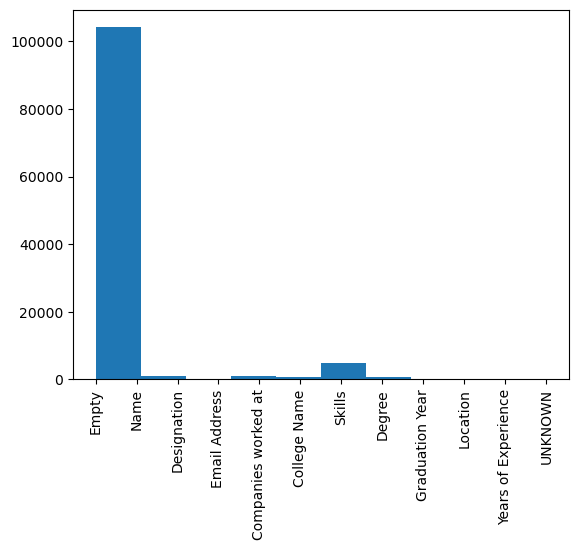

In [77]:
p = plt.hist(np.array(true_labels).flatten())
plt.xticks(rotation='vertical')
plt.show()

In [78]:
from collections import Counter
Counter(np.array(true_labels).flatten())

Counter({np.str_('Empty'): 103155,
         np.str_('Skills'): 4704,
         np.str_('Designation'): 1100,
         np.str_('Name'): 1035,
         np.str_('Companies worked at'): 908,
         np.str_('College Name'): 792,
         np.str_('Degree'): 598,
         np.str_('Location'): 116,
         np.str_('Graduation Year'): 80,
         np.str_('Email Address'): 76,
         np.str_('Years of Experience'): 75,
         np.str_('UNKNOWN'): 1})

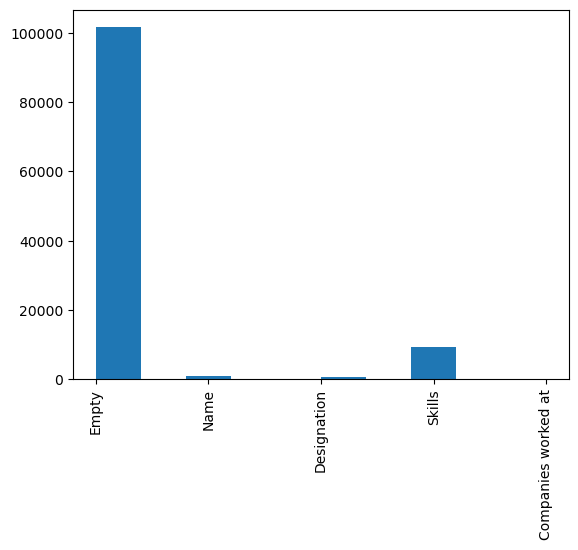

In [79]:
pred_labels = [[id2tag.get(index, "Empty") for index in predictions[i]] for i in range(len(predictions))]
p = plt.hist(np.array(pred_labels).flatten())
plt.xticks(rotation='vertical')
plt.show()